In [2]:
import pandas as pd
import matplotlib.pyplot as plt

x_train_text = pd.read_csv('../data/model_file/text_train_june_previous_feature.csv')
x_test_text = pd.read_csv('../data/model_file/text_test_june_previous_feature.csv')

y_train_text = x_train_text['label']
y_test_text = x_test_text['label']

x_train_audio = pd.read_csv('../data/model_file/audio_train_june_with_previous.csv')
x_test_audio = pd.read_csv('../data/model_file/audio_test_june_with_previous.csv')

y_train_audio = x_train_audio['label']
y_test_audio = x_test_audio['label']

y_train = y_train_audio # since y_train_audio == y_train_text
y_test = y_test_audio # since y_train_audio == y_train_text

print(x_train_text.shape, y_train_text.shape, x_train_audio.shape, y_train_audio.shape)# combine the features upon on wav file name then spli to trainand text

(8024, 3) (8024,) (8024, 74) (8024,)


In [51]:
import numpy as np
import itertools
from sklearn.metrics import f1_score, recall_score, precision_score

In [52]:
# emotion_dict = {'ang': 0,
#                 'hap': 1,
#                 'sad': 2,
#                 'fea': 3,
#                 'sur': 4,
#                 'neu': 5}
emotion_dict = {'ang': 0, 
                'hap': 1, 
                'exc': 2,
                'sad': 3,
                'fru': 4,
                'fea': 5,
                'sur': 6,
                'neu': 7,
                'oth': 8}

emo_keys = list(emotion_dict.keys())

id_to_emotion = {emotion_dict[key]: key for key in emo_keys}

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def one_hot_encoder(true_labels, num_records, num_classes):
    temp = np.array(true_labels[:num_records])
    true_labels = np.zeros((num_records, num_classes))
    true_labels[np.arange(num_records), temp] = 1
    return true_labels

def display_results(y_test, pred_probs, cm=True):
    pred = np.argmax(pred_probs, axis=-1)
    one_hot_true = one_hot_encoder(y_test, len(pred), len(emotion_dict))
    print('Test Set Accuracy =  {0:.3f}'.format(accuracy_score(y_test, pred)))
    print('Test Set F-score =  {0:.3f}'.format(f1_score(y_test, pred, average='macro')))
    print('Test Set Precision =  {0:.3f}'.format(precision_score(y_test, pred, average='macro')))
    print('Test Set Recall =  {0:.3f}'.format(recall_score(y_test, pred, average='macro')))
    if cm:
        plot_confusion_matrix(confusion_matrix(y_test, pred), classes=emo_keys)

In [53]:
cl_weight = dict(pd.Series(x_train_text['label']).value_counts(normalize=True))
cl_weight

{8: 0.252617148554337,
 4: 0.18382352941176472,
 7: 0.17111166500498504,
 0: 0.10780159521435694,
 3: 0.10730309072781655,
 2: 0.10481056829511466,
 1: 0.059322033898305086,
 6: 0.009845463609172482,
 5: 0.003364905284147557}

## Get Text Features

In [54]:
# tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english',max_features=100)
# 
# _ = pd.concat([x_train_text,x_test_text])
# 
# features_text = tfidf.fit_transform(_.transcription).toarray()
# 
# x_train_text = features_text[:x_train_text.shape[0]]
# x_test_text = features_text[-x_test_text.shape[0]:]
# 
# print(features_text.shape, x_train_text.shape, x_test_text.shape)

In [55]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# Assuming x_train_text and x_test_text are your input data.
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english', max_features=100)
all_text = pd.concat([x_train_text, x_test_text])  # Concatenate training and testing text data

# Fit the vectorizer and transform the text data to TF-IDF features
features_text = tfidf.fit_transform(all_text.transcription).toarray()

# Get feature names (column names) from the vectorizer
feature_names = tfidf.get_feature_names_out()

# Split the features back into training and testing sets and convert them to DataFrames with feature names
x_train_text = pd.DataFrame(features_text[:x_train_text.shape[0]], columns=feature_names)
x_test_text = pd.DataFrame(features_text[-x_test_text.shape[0]:], columns=feature_names)

print("Features matrix:", features_text.shape)
print("Train features DataFrame:", x_train_text.shape)
print("Test features DataFrame:", x_test_text.shape)


Features matrix: (10031, 100)
Train features DataFrame: (8024, 100)
Test features DataFrame: (2007, 100)


## Combine Text + Audio Features

In [56]:
x_train_audio.count()

wav_file              8024
label                 8024
sig_mean_previous     8024
sig_std_previous      8024
rmse_mean_previous    8024
                      ... 
mfcc_11_std           8024
mfcc_12_std           8024
mfcc_13_std           8024
mel_mean              8024
mel_std               8024
Length: 74, dtype: int64

In [57]:
x_train_text.count()

annie      8024
ask        8024
away       8024
believe    8024
better     8024
           ... 
wrong      8024
yeah       8024
year       8024
years      8024
yes        8024
Length: 100, dtype: int64

In [58]:
x_train_audio_selected = x_train_audio[x_train_audio.columns.difference(['wav_file', 'label'])]
x_train_audio_array = np.array(x_train_audio_selected)
x_test_audio_selected = x_test_audio[x_test_audio.columns.difference(['wav_file', 'label'])]
x_test_audio_array = np.array(x_test_audio_selected)

combined_x_train = np.concatenate((x_train_audio_array, x_train_text), axis=1)
# combined_x_train = x_train_audio_array

combined_x_test = np.concatenate((x_test_audio_array, x_test_text), axis=1)
# combined_x_test = x_test_audio_array

print(combined_x_train.shape, combined_x_test.shape)

combined_features_dict = {}

combined_features_dict['x_train'] = combined_x_train
combined_features_dict['x_test'] = combined_x_test
combined_features_dict['y_train'] = np.array(y_train)
combined_features_dict['y_test'] = np.array(y_test)

# with open('../data/model_file/combined_features.pkl', 'wb') as f:
#     pickle.dump(combined_features_dict, f)

(8024, 172) (2007, 172)


In [59]:
combined_x_train

array([[0.00127075, 0.00058752, 0.00649743, ..., 0.        , 0.        ,
        0.        ],
       [0.02774078, 0.00066633, 0.37781427, ..., 0.        , 0.        ,
        0.        ],
       [0.00270381, 0.00074604, 0.01540097, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.00310395, 0.01209679, 0.01073084, ..., 0.        , 0.        ,
        0.        ],
       [0.0006409 , 0.0029447 , 0.00851171, ..., 0.        , 0.        ,
        0.        ],
       [0.00607322, 0.00129432, 0.05653616, ..., 0.        , 0.        ,
        0.        ]])

In [7]:
# rf_classifier = RandomForestClassifier(n_estimators=600, min_samples_split=25)
# rf_classifier.fit(combined_x_train, y_train)
# 
# # Predict
# pred_probs = rf_classifier.predict_proba(combined_x_test)
# 
# # Results
# display_results(y_test, pred_probs)
# 
# with open('../data/model/pred_probas/combined_rf_classifier.pkl', 'wb') as f:
#     pickle.dump(pred_probs, f)
# 
# with open('../data/model/combined_RF.pkl', 'wb') as f:
#     pickle.dump(rf_classifier, f)

NameError: name 'combined_x_train' is not defined

/Users/sensenc/anaconda3/envs/sound_detection_project/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [14:10:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "cl_weight", "random_stat" } are not used.

  warnings.warn(smsg, UserWarning)


Test Set Accuracy =  0.424
Test Set F-score =  0.308
Test Set Precision =  0.349
Test Set Recall =  0.301
Confusion matrix, without normalization
[[108   0   7   0  62   0   0   6  53]
 [  0   3  20  10  10   0   0  16  60]
 [  8   6  65   0  22   0   0  19  80]
 [  1   0   0 125   9   0   0  13  75]
 [ 27   0  10  12 155   0   0  35 133]
 [  0   0   0   1   0   0   0   2  10]
 [  1   0   3   2   6   0   0   2  14]
 [  5   1   8  22  60   0   0 118 121]
 [ 25   2  25  28  71   0   0  53 277]]


/Users/sensenc/anaconda3/envs/sound_detection_project/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


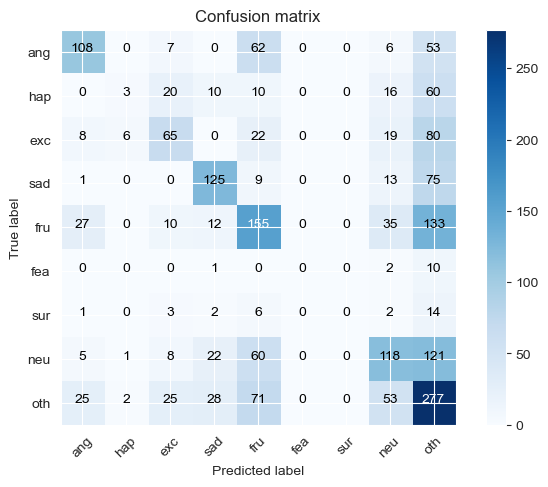

In [62]:
import xgboost as xgb
import pickle

xgb_classifier = xgb.XGBClassifier(booster= 'gbtree', colsample_bytree= 0.3, learning_rate= 0.05, max_depth= 7, n_estimators= 300, subsample=0.8, n_jobs=4,cl_weight=cl_weight,random_stat=42)
xgb_classifier.fit(combined_x_train, y_train)
#Best parameters found:  {'booster': 'gbtree', 'colsample_bytree': 0.3, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.8}


# Predict
pred_probs = xgb_classifier.predict_proba(combined_x_test)

# Results
display_results(y_test, pred_probs)

with open('../data/model/pred_probas/combined_xgb_classifier_previous.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

with open('../data/model/combined_XGB_previous.pkl', 'wb') as f:
    pickle.dump(xgb_classifier, f)

In [63]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Define the parameter grid for XGBoost
param_grid = {
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'booster': ['gbtree', 'gblinear'],
    'colsample_bytree': [0.3, 0.7],
    'subsample': [0.5, 0.8]
}

# Initialize the classifier
xgb_classifier = xgb.XGBClassifier(objective='multi:softprob', num_class=len(emotion_dict), n_jobs=4,cl_weight=cl_weight)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, cv=3, scoring='accuracy', verbose=1)

# Fit the model
grid_search.fit(combined_x_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

# Train the model with the best parameters
best_model = grid_search.best_estimator_

# Evaluate on the training set
train_predictions = best_model.predict(combined_x_train)
train_accuracy = accuracy_score(y_train, train_predictions)
train_classification_report = classification_report(y_train, train_predictions)
train_confusion_matrix = confusion_matrix(y_train, train_predictions)

print("Training set performance:")
print("Accuracy: ", train_accuracy)
print("Classification Report:\n", train_classification_report)
print("Confusion Matrix:\n", train_confusion_matrix)

# Evaluate on the test set
test_predictions = best_model.predict(combined_x_test)
test_accuracy = accuracy_score(y_test, test_predictions)
test_classification_report = classification_report(y_test, test_predictions)
test_confusion_matrix = confusion_matrix(y_test, test_predictions)

print("Test set performance:")
print("Accuracy: ", test_accuracy)
print("Classification Report:\n", test_classification_report)
print("Confusion Matrix:\n", test_confusion_matrix)


Fitting 3 folds for each of 288 candidates, totalling 864 fits


/Users/sensenc/anaconda3/envs/sound_detection_project/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [14:10:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "cl_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/sensenc/anaconda3/envs/sound_detection_project/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [14:10:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "cl_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/sensenc/anaconda3/envs/sound_detection_project/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [14:10:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "cl_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/sensenc/anaconda3/envs/sound_detection_project/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [14:10:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:

Best parameters found:  {'booster': 'gbtree', 'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
Training set performance:
Accuracy:  0.7916251246261217
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.78      0.82       865
           1       0.99      0.63      0.77       476
           2       0.95      0.78      0.86       841
           3       0.79      0.87      0.83       861
           4       0.81      0.79      0.80      1475
           5       1.00      0.89      0.94        27
           6       1.00      0.94      0.97        79
           7       0.86      0.67      0.76      1373
           8       0.67      0.88      0.76      2027

    accuracy                           0.79      8024
   macro avg       0.88      0.80      0.83      8024
weighted avg       0.81      0.79      0.79      8024

Confusion Matrix:
 [[ 673    1    2    1   71    0    0   13  104]

/Users/sensenc/anaconda3/envs/sound_detection_project/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sensenc/anaconda3/envs/sound_detection_project/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sensenc/anaconda3/envs/sound_detection_project/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

wouldn: 0.01662360318005085
um: 0.014896871522068977
sig_std: 0.01385783962905407
laughter: 0.013064436614513397
excited: 0.012893464416265488
things: 0.011699915863573551
just don: 0.011327333748340607
sig_mean: 0.010556924156844616
rmse_mean: 0.010266798548400402
sure: 0.01013786718249321
turn: 0.010064375586807728
great: 0.00988799799233675
okay: 0.009681154042482376
line: 0.009540049359202385
point: 0.009471648372709751
flashlight: 0.009428881108760834
really: 0.009420731104910374
live: 0.009364232420921326
laugh: 0.00924843829125166
isn: 0.00901144277304411
yeah: 0.009000161662697792
need: 0.008992020040750504
doing: 0.008803359232842922
job: 0.008690648712217808
look: 0.008690549992024899
mfcc_6_mean: 0.008682227693498135
know like: 0.008618813939392567
rmse_std: 0.00860392116010189
oh: 0.00857167225331068
come: 0.008510272018611431
day: 0.008458429016172886
thank: 0.008440283127129078
good: 0.008298545144498348
love: 0.008293723687529564
long: 0.008202948607504368
know: 0.008054

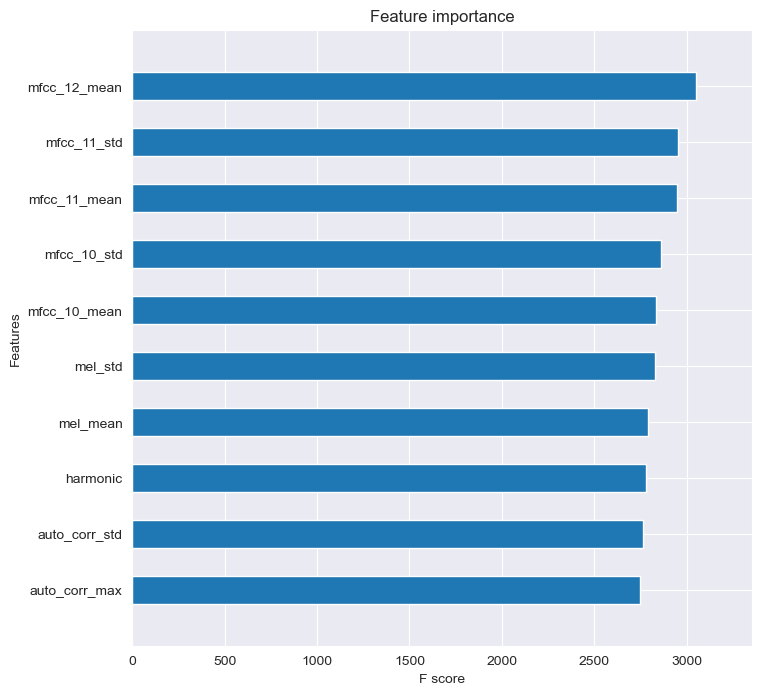

In [77]:
# Extract feature names from x_train_audio and x_train_text
audio_feature_names = x_train_audio.columns.difference(['wav_file', 'label']).tolist()
text_feature_names = pd.DataFrame(x_train_text).columns.to_list()


# Combine feature names
combined_feature_names = audio_feature_names + text_feature_names


# Plot feature importances
ax = xgb.plot_importance(xgb_classifier, max_num_features=10, height=0.5, show_values=False)
fig = ax.figure
fig.set_size_inches(8, 8)

# Add feature names to the plot
ax.set_yticklabels([combined_feature_names[i] for i in ax.get_yticks().astype(int)])

# Save the plot
plt.savefig('feature_importance.png')

# Print contribution scores with feature names
contribution_scores = xgb_classifier.feature_importances_
feature_importance_dict = {feature: score for feature, score in zip(combined_feature_names, contribution_scores)}

# Sort the feature importance dictionary by the importance scores
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True)

# Print sorted feature importances
for feature, importance in sorted_feature_importance:
    print(f"{feature}: {importance}")

> threshold=0.0046525862999260426, features=136, accuracy=0.6008744534665834
> threshold=0.005073350854218006, features=135, accuracy=0.6046221111805122
> threshold=0.005162385292351246, features=134, accuracy=0.603372891942536
> threshold=0.005244228523224592, features=133, accuracy=0.5965021861336665
> threshold=0.005301071330904961, features=132, accuracy=0.5952529668956902
> threshold=0.005311253946274519, features=131, accuracy=0.5952529668956902
> threshold=0.005327759310603142, features=130, accuracy=0.5927545284197376
> threshold=0.005333650391548872, features=129, accuracy=0.5883822610868208
> threshold=0.005349559709429741, features=128, accuracy=0.5908806995627732
> threshold=0.005359828006476164, features=127, accuracy=0.5940037476577139
> threshold=0.005384606309235096, features=126, accuracy=0.5965021861336665
> threshold=0.005471209064126015, features=125, accuracy=0.5940037476577139
> threshold=0.005476470571011305, features=124, accuracy=0.5883822610868208
> threshold=

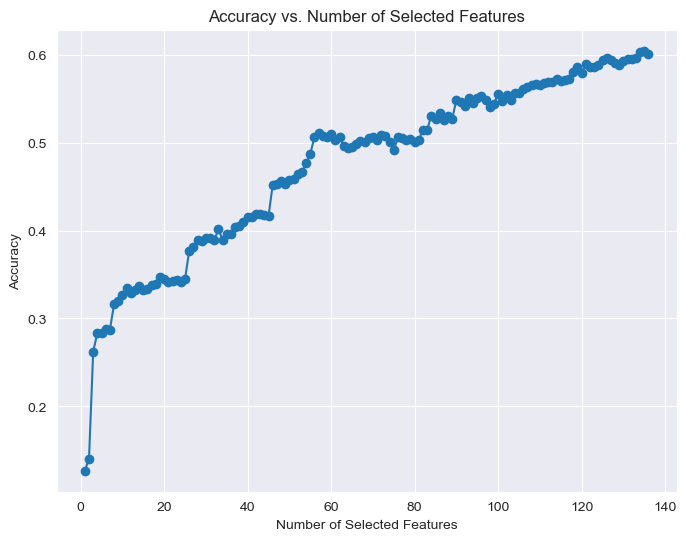

Optimal Threshold: 0.0051
Number of Selected Features: 135
Accuracy at Optimal Threshold: 0.6046


In [80]:
# Get the feature importance scores
importance_scores = xgb_classifier.feature_importances_

# Define a range of threshold values
thresholds = np.sort(xgb_classifier.feature_importances_)

# Initialize lists to store the results
num_features = []
accuracies = []

# Iterate over the threshold values
for threshold in thresholds:
    # Select features using the current threshold
    selector = SelectFromModel(xgb_classifier, threshold=threshold, prefit=True)
    X_train_selected = selector.transform(combined_x_train)
    X_test_selected = selector.transform(combined_x_test)

    # Train a new XGBoost model with the selected features
    selected_model = xgb.XGBClassifier(n_estimators=300, learning_rate=0.05, random_state=42)
    selected_model.fit(X_train_selected, y_train)

    # Evaluate the model on the test set
    y_pred = selected_model.predict(X_test_selected)
    accuracy = accuracy_score(y_test, y_pred)

    # Store the number of selected features and accuracy
    num_features.append(X_train_selected.shape[1])
    accuracies.append(accuracy)

    # Report progress
    print(f'> threshold={threshold}, features={X_train_selected.shape[1]}, accuracy={accuracy}')

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(num_features, accuracies, marker='o')
plt.xlabel('Number of Selected Features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Selected Features')
plt.grid(True)
plt.show()

# Find the optimal threshold
optimal_threshold_index = np.argmax(accuracies)
optimal_threshold = thresholds[optimal_threshold_index]
optimal_num_features = num_features[optimal_threshold_index]

print(f"Optimal Threshold: {optimal_threshold:.4f}")
print(f"Number of Selected Features: {optimal_num_features}")
print(f"Accuracy at Optimal Threshold: {accuracies[optimal_threshold_index]:.4f}")

Test Set Accuracy =  0.649
Test Set F-score =  0.662
Test Set Precision =  0.664
Test Set Recall =  0.666
Confusion matrix, without normalization
[[125   7  64   7   5  16]
 [  8 190  36   8  11  47]
 [ 42  33 392  16  24  76]
 [  0   0  15 232   0   0]
 [  1   3  25  14 198   0]
 [ 20  48 135  14  12 136]]


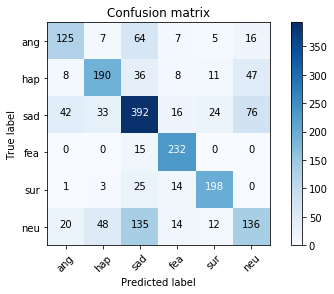

In [9]:
svc_classifier = LinearSVC()

svc_classifier.fit(combined_x_train, y_train)

# Predict
pred = svc_classifier.predict(combined_x_test)

# Results
one_hot_true = one_hot_encoder(y_test, len(pred), len(emotion_dict))
print('Test Set Accuracy =  {0:.3f}'.format(accuracy_score(y_test, pred)))
print('Test Set F-score =  {0:.3f}'.format(f1_score(y_test, pred, average='macro')))
print('Test Set Precision =  {0:.3f}'.format(precision_score(y_test, pred, average='macro')))
print('Test Set Recall =  {0:.3f}'.format(recall_score(y_test, pred, average='macro')))
plot_confusion_matrix(confusion_matrix(y_test, pred), classes=emo_keys)
(y_test, pred_probs)

with open('pred_probas/combined_svc_classifier_model.pkl', 'wb') as f:
    pickle.dump(svc_classifier, f)
    
with open('trained_models/combined/SVC.pkl', 'wb') as f:
    pickle.dump(svc_classifier, f)

Test Set Accuracy =  0.607
Test Set F-score =  0.608
Test Set Precision =  0.719
Test Set Recall =  0.574
Confusion matrix, without normalization
[[ 88  13 107   3   5   8]
 [  4 166  94   3   8  25]
 [ 18  20 509   3   9  24]
 [  0   0  70 177   0   0]
 [  0   8  74   0 159   0]
 [  4  30 224   9   7  91]]


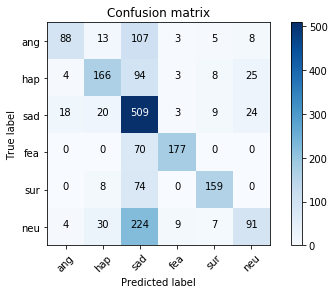

In [10]:
mnb_classifier = MultinomialNB()

mnb_classifier.fit(combined_x_train, y_train)

# Predict
pred_probs = mnb_classifier.predict_proba(combined_x_test)

# Results
display_results(y_test, pred_probs)

with open('pred_probas/combined_mnb_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)
    
with open('trained_models/combined/MNB.pkl', 'wb') as f:
    pickle.dump(mnb_classifier, f)

Test Set Accuracy =  0.665
Test Set F-score =  0.681
Test Set Precision =  0.676
Test Set Recall =  0.690
Confusion matrix, without normalization
[[120  17  63   3   3  18]
 [ 13 182  35   6  12  52]
 [ 50  42 381   9  17  84]
 [  0   0   0 247   0   0]
 [  1   0  10   3 227   0]
 [ 22  57 126   5   8 147]]


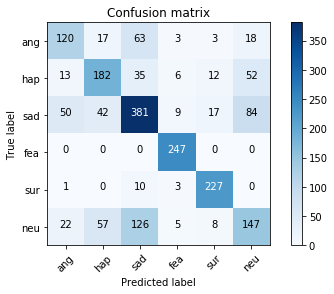

In [11]:
mlp_classifier = MLPClassifier(hidden_layer_sizes=(500, ), activation='relu', solver='adam', alpha=0.0001,
                               batch_size='auto', learning_rate='adaptive', learning_rate_init=0.01,
                               power_t=0.5, max_iter=1000, shuffle=True, random_state=None, tol=0.0001,
                               verbose=False, warm_start=True, momentum=0.8, nesterovs_momentum=True,
                               early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999,
                               epsilon=1e-08)

mlp_classifier.fit(combined_x_train, y_train)

# Predict
pred_probs = mlp_classifier.predict_proba(combined_x_test)

# Results
display_results(y_test, pred_probs)

with open('pred_probas/combined_mlp_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)
    
with open('trained_models/combined/MLP.pkl', 'wb') as f:
    pickle.dump(mlp_classifier, f)

Test Set Accuracy =  0.631
Test Set F-score =  0.643
Test Set Precision =  0.686
Test Set Recall =  0.620
Confusion matrix, without normalization
[[119   8  77   1   5  14]
 [  9 175  59   4  14  39]
 [ 28  29 450   4  18  54]
 [ 10   0  53 184   0   0]
 [  5   7  49   2 173   5]
 [  7  34 166   9  13 136]]


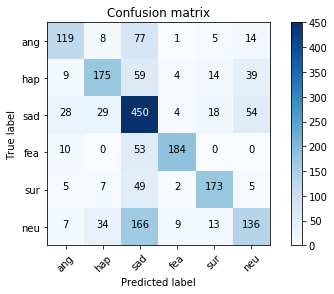

In [12]:
lr_classifier = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000)

lr_classifier.fit(combined_x_train, y_train)

# Predict
pred_probs = lr_classifier.predict_proba(combined_x_test)

# Results
display_results(y_test, pred_probs)

with open('pred_probas/combined_lr_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)
    
with open('trained_models/combined/LR.pkl', 'wb') as f:
    pickle.dump(lr_classifier, f)

[0.00794865 0.00733964 0.00552868 ... 0.         0.         0.        ]


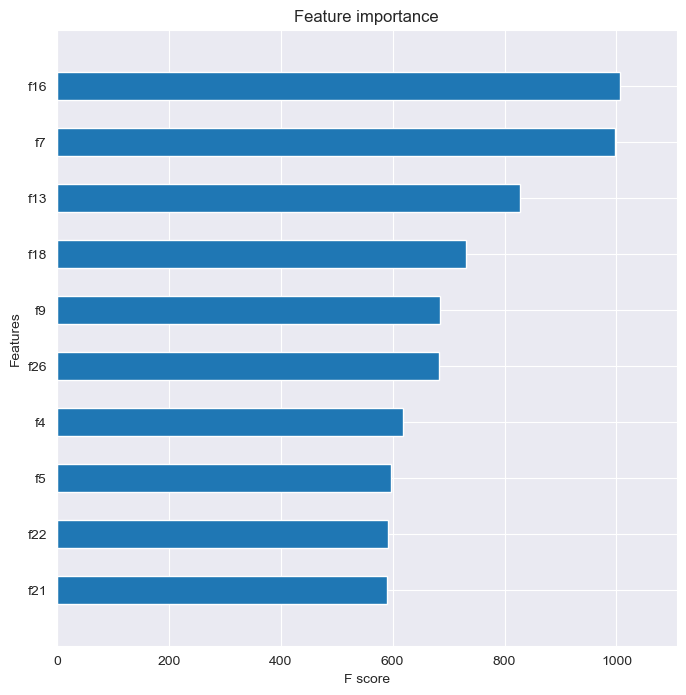

Test Set Accuracy =  0.707
Test Set F-score =  0.716
Test Set Precision =  0.735
Test Set Recall =  0.713
Confusion matrix, without normalization
[[117  11  81   1   3  11]
 [ 11 175  54   4   8  48]
 [ 30  28 470   2   7  46]
 [  0   0   0 247   0   0]
 [  0   0   3   0 238   0]
 [ 12  42 159   6   7 139]]


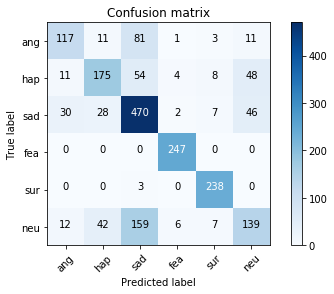

In [17]:
# Load predicted probabilities
with open('pred_probas/combined_rf_classifier.pkl', 'rb') as f:
    rf_pred_probs = pickle.load(f)

with open('pred_probas/combined_xgb_classifier.pkl', 'rb') as f:
    xgb_pred_probs = pickle.load(f)
    
with open('pred_probas/combined_svc_classifier_model.pkl', 'rb') as f:
    svc_preds = pickle.load(f)
    
with open('pred_probas/combined_mnb_classifier.pkl', 'rb') as f:
    mnb_pred_probs = pickle.load(f)
    
with open('pred_probas/combined_mlp_classifier.pkl', 'rb') as f:
    mlp_pred_probs = pickle.load(f)
    
with open('pred_probas/combined_lr_classifier.pkl', 'rb') as f:
    lr_pred_probs = pickle.load(f)

with open('pred_probas/combined_lstm_classifier.pkl', 'rb') as f:
    lstm_pred_probs = pickle.load(f)

# Average of the predicted probabilites
ensemble_pred_probs = (xgb_pred_probs +
                       mlp_pred_probs +
                       rf_pred_probs +
                       mnb_pred_probs +
                       lr_pred_probs)/5.0
# Show metrics
display_results(y_test, ensemble_pred_probs)